# Quantum Layer

## Encoder

In [1]:
from ionqvision.ansatze import VariationalAnsatz
import numpy as np
import symengine as symeng

from math import ceil, log, floor
from ionqvision.ansatze import VariationalAnsatz
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterExpression, ParameterVector
from qiskit.quantum_info import SparsePauliOp

import numpy as np
import symengine as symeng

from math import ceil, log, floor
from ionqvision.ansatze import VariationalAnsatz
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterExpression, ParameterVector
from qiskit.quantum_info import SparsePauliOp
from qiskit.quantum_info import Statevector
import math

class AmplitudeEncoder(VariationalAnsatz):
    def __init__(self, num_qubits, param_prefix="x"):
        super().__init__(num_qubits)

        d = int(log(num_qubits, 2))
        if not np.isclose(log(num_qubits, 2), d):
            raise ValueError("num_qubits must be a power of 2")

        x = ParameterVector(param_prefix, num_qubits)
        x = np.array([i for i, qbt in enumerate(x)])
        x = x / np.sqrt(np.sum(x ** 2))
        self.initialize(Statevector(x), [i for i in range(int(math.sqrt(num_qubits)))])
        self.to_instruction()

class AngleEncoder(VariationalAnsatz):
    def __init__(self, num_qubits, entanglement_depth=1, param_prefix="x"):
        super().__init__(num_qubits)

        x = ParameterVector(param_prefix, num_qubits)
        [self.ry(np.pi * xi, qbt) for qbt, xi in enumerate(x)]

        for k in range(entanglement_depth):
            top_qubit = 0
            while top_qubit < num_qubits - (k + 1):
                self.cx(top_qubit, top_qubit + k + 1)
                top_qubit += 1
        

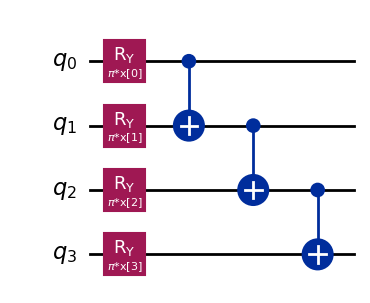

In [2]:
encoder = AngleEncoder(num_qubits=4)
encoder.draw("mpl")

## Ansatze

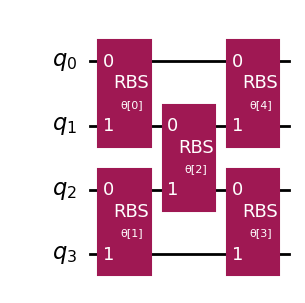

In [3]:
from ionqvision.ansatze.ansatz_library import QCNNAnsatz, ButterflyOrthogonalAnsatz, CrossOrthogonalAnsatz, BrickworkLayoutAnsatz
# CrossOrthogonal Best = 66; Depth 3 = 61
# BrickworkLayoutAnsatz Best = 60
# QCNNAnsatz Best = 61
# ButterflyOrthogonalAnsatz Best = 56
# 0 Best = 62

class Ansatz0(VariationalAnsatz):
    def __init__(self, num_qubits, num_layers, param_prefix="θ", blk_sz=1, qubits=None, initial_state=None):
        super().__init__(num_qubits)
        if initial_state is not None:
            self.compose(initial_state, inplace=True)
            self.barrier()
            
        x = ParameterVector(param_prefix, num_qubits)
        [self.ry(np.pi * xi, qbt) for qbt, xi in enumerate(x)]
        top_qubit = 0
        while top_qubit < num_qubits - 1:
            self.cx(top_qubit, top_qubit + 1)
            top_qubit += 1
        self.cx(3,0)

class Ansatz1(VariationalAnsatz):
    def __init__(self, num_qubits, num_layers, param_prefix="θ", blk_sz=1, qubits=None, initial_state=None):
        super().__init__(num_qubits)
        if num_qubits % 2:
            raise ValueError("num_qubits must be even")

        x = ParameterVector("M", num_qubits)
        [self.ry(np.pi * xi, qbt) for qbt, xi in enumerate(x)]
        
        top_qubit = 0
        while top_qubit < num_qubits - 1:
            self.cx(top_qubit, top_qubit + 1)
            top_qubit += 1
        self.cx(3,0)
        
        theta = iter(ParameterVector(param_prefix, 2*num_qubits - 3))
        for j in range(num_qubits-1):
            self.rbs(next(theta), j, j+1)
            if j != num_qubits - j - 2:
                self.rbs(next(theta), -2-j, -1-j)

H = SparsePauliOp.from_list([("ZZ", 1), ("XI", -2), ("IZ", 3)])
ansatz = CrossOrthogonalAnsatz(num_qubits=4)
ansatz.draw("mpl")

## Quantum Features

In [4]:
from qiskit.quantum_info import SparsePauliOp

# Measure the expectation value of X_0, Y_0, Z_0
quantum_features = [
    SparsePauliOp(["IIIX"]), 
    SparsePauliOp(["IIIY"]), 
    SparsePauliOp(["IIIZ"])
]

# Training

In [5]:
from ionqvision.modules import BinaryMNISTClassifier
import logging

logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

# Set up your classifier and inspect its architecture
classifier = BinaryMNISTClassifier(encoder, ansatz, quantum_features); classifier

BinaryMNISTClassifier(
  (latent_vec_encoder): Sequential(
    (0): Linear(in_features=168, out_features=4, bias=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): Sigmoid()
  )
  (quantum_layer): QuantumModule()
  (prediction_head): Sequential(
    (0): Linear(in_features=3, out_features=1, bias=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): Sigmoid()
  )
)

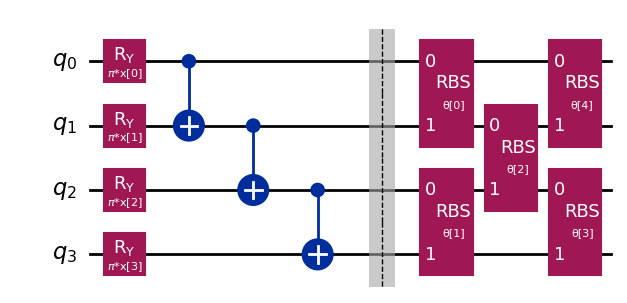

In [6]:
classifier.quantum_layer.layer_qc.draw("mpl")

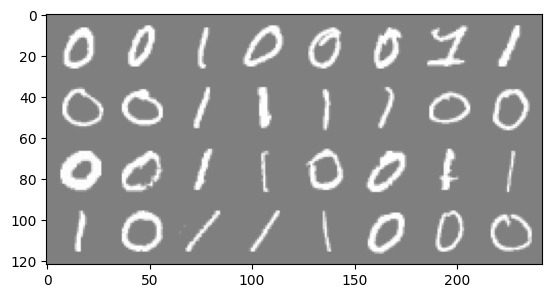

In [7]:
classifier.visualize_batch()

epoch:   1 | loss: 0.707
lr: 0.1000 | processed     1/   10 batches per epoch in 142.82s (4.30s forward / 88.42s backward)
Model achieved 47.167%  accuracy on TRAIN set.
Model achieved 49.000%  accuracy on TEST set.

epoch:   1 | loss: 0.700
lr: 0.1000 | processed     2/   10 batches per epoch in 319.30s (5.80s forward / 120.37s backward)
Model achieved 45.333%  accuracy on TRAIN set.
Model achieved 54.000%  accuracy on TEST set.

epoch:   1 | loss: 0.700
lr: 0.1000 | processed     3/   10 batches per epoch in 469.60s (5.13s forward / 92.77s backward)
Model achieved 44.333%  accuracy on TRAIN set.
Model achieved 51.000%  accuracy on TEST set.

epoch:   1 | loss: 0.700
lr: 0.1000 | processed     4/   10 batches per epoch in 616.30s (4.00s forward / 91.30s backward)
Model achieved 46.333%  accuracy on TRAIN set.
Model achieved 50.000%  accuracy on TEST set.

epoch:   1 | loss: 0.701
lr: 0.1000 | processed     5/   10 batches per epoch in 781.82s (4.51s forward / 92.00s backward)
Model ac

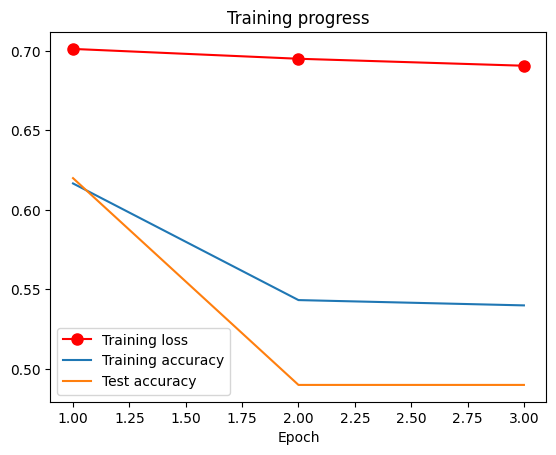

In [8]:
%%time
# Get a (pre-processed) training and test set
train_set, test_set = classifier.get_train_test_set(train_size=600, test_size=100)

# Configure model training hyper parameters
config = {
    "epochs": 3,
    "lr": 0.1,
    "batch_size": 60,
    "betas": (0.9, 0.99),
    "weight_decay": 1e-3,
    "clip_grad": True,
    "log_interval": 1,
}

# Train and plot the results
classifier.train_module(train_set, test_set, config)
classifier.plot_training_progress()

# Grading

In [9]:
from qbraid.runtime import QbraidSession
from ionqvision.scq_client import IonQSCQClient

session = QbraidSession()

client = IonQSCQClient(session=session)

submission_data = classifier.submit_model_for_grading(client=client)

message = submission_data.get("message")
submission_id = submission_data.get("submissionId")

print(message)

Submission received. Autograder in progress.


In [10]:
client.await_autograder_result(submission_id=submission_id)

{'_id': '670a73ffc4732bc65c8220d4',
 'submittedBy': 'aayalal@ncsu.edu',
 'status': 'succeeded',
 'statusMessage': 'Submission graded successfully.',
 'executionId': 'ionq-scquantum-h5gmd',
 'executionSec': 59,
 'score': 62,
 'createdAt': '2024-10-12T13:05:03.684Z',
 'updatedAt': '2024-10-12T13:05:03.684Z',
 'success': True}